# Violin Mode Damper Analysis by Impedance Networks

These are resonant dampers installed on the PUM mass to absorb energy from the violin modes. Energy must be coupled through the 40kg PUM mass. This is an impedance network calculation to show the relation of damper mass/loss parameters to the loss in the violin mode.

The wikipedia page on the [Mobility Analogy](https://en.wikipedia.org/wiki/Mobility_analogy) gives the relations. 

 * NOTE there is also the [Impedance Analogy](https://en.wikipedia.org/wiki/Impedance_analogy) for mechanical systems. But this analogy does not preserve the mechanical/electrical topologies (electrical becomes the dual of mechanical).
 
The basic idea of this analogy is to use electrical phasors/s-domain tools for mechanical calculations. The notion of impedance works the same, and in the analogy takes on units of $\frac{\mathrm{s}}{\mathrm{kg}}$. In this case *current* becomes *force* and *voltage* becomes *velocity*. It is also possibly to use definitions where voltage becomes displacement (useful for DC calculations), but this is not standard.

 * Masses become capacitors $Z_\text{mass} = \frac{1}{i \omega M}$
 * Springs become inductors $Z_\text{spring}  = \frac{i \omega}{k}$
 * Viscous Damping become resistors
 * And loss angle for springs adds a real part proportional to $1/k$ and $\theta$

In generate the loss angle for an impedance can be calculated as $\theta_\text{loss} = \frac{\Re{(Z)}}{|Z|}$. The procedure here will be to calculate the impedance of the violin mode with/without a damper attached and then show the reduction in the loss angle of the violin mode when the damper is installed.

For this analogy, the Johnson-Nyquist formulas for noise also apply. At the end of the notebook, the displacement noise of the test mass is calculated. It is shown that these dampers will decrease the violin modes.

### Notebook Setup

In [1]:
import sys
#in case of python2
from __future__ import division
import numpy as np

#setup the notebook
from IPython.display import display, Image
%load_ext autoreload
%autoreload 2
%matplotlib inline
%pylab inline

mpl.rcParams['axes.facecolor'] = 'FFFFFF'
mpl.rcParams['figure.facecolor'] = 'FFFFFF'
mpl.rcParams['figure.dpi'] = 130
mpl.rcParams['savefig.dpi'] = 92
mpl.rcParams['figure.figsize'] = [7.0, 3.0]

import sympy
print("Sympy version: ", sympy.__version__)
sympy.init_printing(use_latex=True)

Populating the interactive namespace from numpy and matplotlib
Sympy version:  1.0


## Problem Diagram

The problem is setup as a double pendulum with just the penultimate mass (the PUM) and the ultimate testmass at the bottom (the TM). These are both 40kg in aLIGO.

The suspension fibers act like a pendulum spring and the violin modes act as additional spring-mass systems within them.

These can be expressed with mechanical schematics

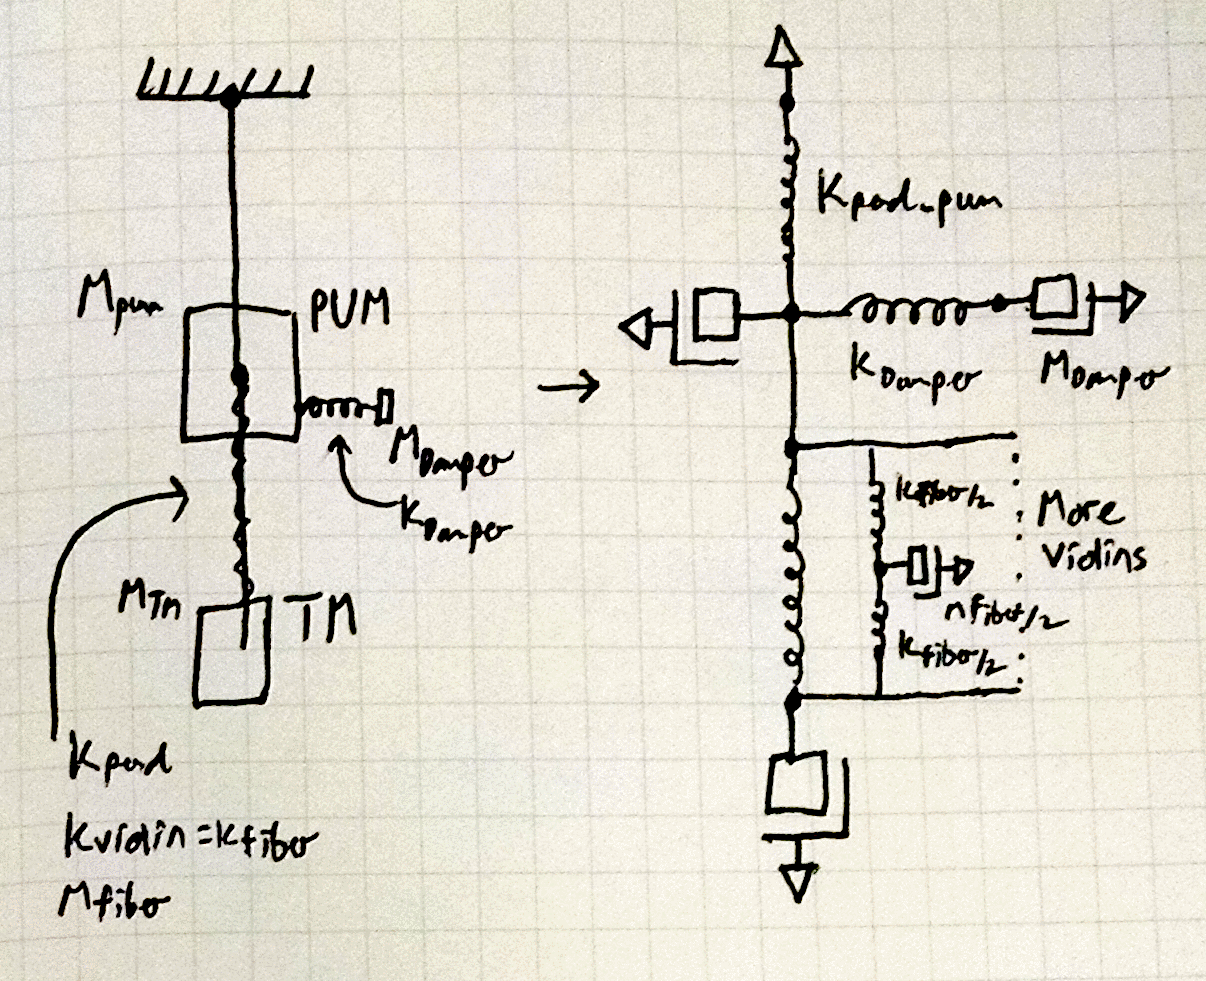

In [2]:
Image('./Mech1.png', embed = True)

This can then be changed to the equivalent electrical diagram. To calculate various noise, power and transfer couplings amounts to calculating the impedance between points. In particular for noise, we need to calculate the impedance to ground for any reference point. That impedance can tell the loss, thermal noise and modal mass of the system at every frequency.

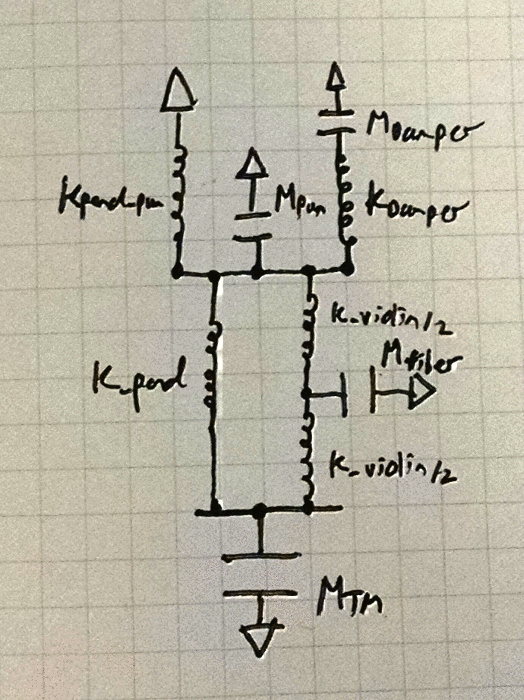

In [3]:
Image('./MechElec1.png', embed = True)

### Violin Mode loss
For the violin modes, the reference point is the attachment to the M_fiber connection. We can calculate the impedance easily using serial and parallel formulas. For simplicity the pendulum modes are dropped. They will be reintroduced later

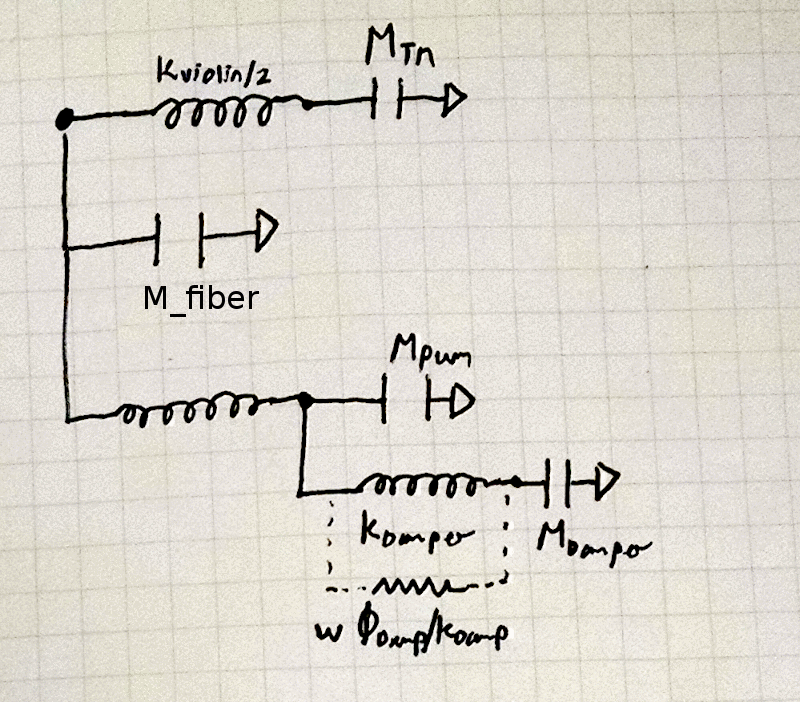

In [4]:
Image('./Electric1.png', embed = True)

### Define Variables and relations

In [5]:
#for later thermal noise calculations
k_boltzman = 1.38064852e-23 #J/K
temp_K = 300


Mtm_kg = sympy.var('M_TM', real = True)
#make the pum the same as testmass, but semantic naming for clarity
Mpum_kg = Mtm_kg

#frequency of evaluation
F = sympy.var('F', real = True)

#variables for fiber mode
F_vio_Hz = sympy.var('F_vio', real = True)
M_fiber_kg = sympy.var('M_fiber', real = True)
k_fiber_N_m = (sympy.pi * 2 * F_vio)**2 * M_fiber
detune_F_D_Hz = sympy.var('F_Delta', real = True)
loss_fiber = 1e-9

#variables for damper mode
loss_D = sympy.var('theta_D', real = True)
M_D_kg = sympy.var('M_D', real = True)
k_D_N_m = (sympy.pi * 2 * (F_vio_Hz + detune_F_D_Hz))**2 * M_D_kg

#variables for pendulum mode
F_pend_Hz = sympy.var('F_pend', real = True)
#here we use the reduced mass between TM and PUM
k_pend_N_m = (sympy.pi * 2 * F_pend_Hz)**2 * Mtm_kg/2
k_pend_TMadj_N_m = k_pend_N_m - k_fiber_N_m

#for the PUM resonance, lower the frequency by 2x
k_pendPUM_N_m = (sympy.pi * 2 * F_pend_Hz/2)**2 * Mtm_kg

loss_pend = 1e-7


def Zseries(*args):
    return sum(args)

#sympy wont simplify the universal expression in the final "else" clause, so for args up to 3 I
#presimplify to help sympy along
def Zparallel(*args):
    if len(args) == 1:
        return args[0]
    elif len(args) == 2:
        a, b = args
        return a*b / (a + b)
    elif len(args) == 3:
        a, b, c = args
        return a*b*c / (a*b + b*c + a*c)
    else:
        s = 1/args[0]
        for v in args[1:]:
            s = s + 1/v
        return 1/s

def Zspring(k_N_m, loss = 0):
    return sympy.I * 2 * sympy.pi * F/ (k_N_m * (1 + sympy.I * loss))

def Zmass(m_kg):
    return 1/(sympy.I * 2 * sympy.pi * F * m_kg)

def logspaced(lower, upper, n_points):
    'helper to generate samplings for plots'
    log_lower = np.log(lower)
    log_upper = np.log(upper)
    return np.exp(np.linspace(log_lower, log_upper, n_points))

### Previews

Just check that the formulas are reasonable

In [6]:
k_D_N_m

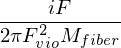

In [7]:
Zspring(k_fiber_N_m)

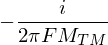

In [8]:
Zmass(Mtm_kg)

## Construct impedance

The previous tree-level schematic can be reduced into parallel and serial impedance formulas to calculate the wave impedance of the fiber mode and therefor the loss as well.

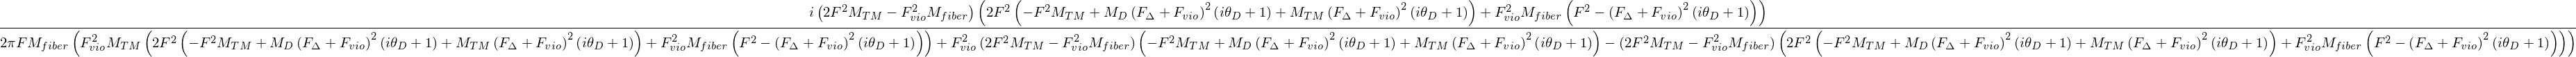

In [9]:
imp = Zparallel(
    Zseries(Zspring(k_fiber_N_m/2), Zmass(Mtm_kg)),
    Zmass(M_fiber_kg),
    Zseries(
        Zspring(k_fiber_N_m/2), 
        Zparallel(
            Zmass(Mpum_kg),
            Zseries(
                Zspring(k_D_N_m, loss = loss_D),
                Zmass(M_D_kg),
            )
        )
    ),
)
imp = imp.simplify()
imp

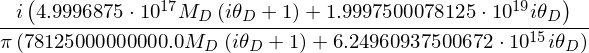

In [10]:
subst = imp.subs([(F, F_vio)]).subs({
        Mtm_kg: 40,
        M_fiber_kg: .005,
        F_vio_Hz: 500,
        detune_F_D_Hz : 0,
    })
subst = subst.simplify()
subst

In [11]:
val = subst.subs({
    loss_D: 1e-2,
    M_D: .4,
})
print("Impedance [s/kg]")
display(abs(val).evalf())
val = (val / abs(val))
print("Relative Loss")
display(sympy.re(val).evalf())

Impedance [s/kg]


Relative Loss


In [12]:
val = subst.subs({
    loss_D: 1e-5, 
    M_D: .00001
})
print("Impedance [s/kg]")
display(abs(val).evalf())
val = (val / abs(val))
print("Relative Loss")
display(sympy.re(val).evalf())

Impedance [s/kg]


Relative Loss


In [13]:
val = subst.subs({
    loss_D: 1e-2, 
    M_D: .01,
})
print("Impedance [s/kg]")
display(abs(val).evalf())
val = (val / abs(val))
print("Relative Loss")
display(sympy.re(val).evalf())

Impedance [s/kg]


Relative Loss


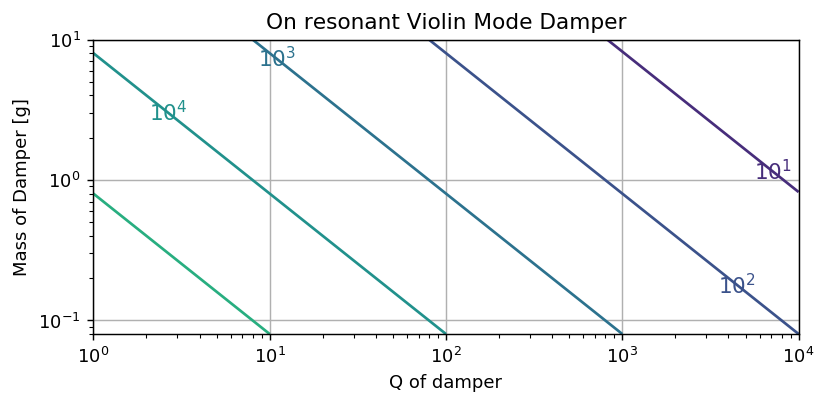

In [14]:
subst = imp.subs([(F, F_vio)]).subs({
        Mtm_kg: 40,
        M_fiber_kg: .005,
        F_vio_Hz: 500.,
        detune_F_D_Hz : 0.,
    })
loss_eval = sympy.lambdify([loss_D, M_D], subst / abs(subst), ['numpy', 'math'])

def contour_loss(loss_eval):
    p_loss_D = logspaced(1e-4, 1, 200)
    p_M_D = logspaced(.8e-4, 1e-2, 200)
    #

    loss_arr = -np.log10(loss_eval(*np.meshgrid(p_loss_D, p_M_D)).real)

    fig = pylab.figure()
    ax = fig.add_subplot(1,1,1)
    CP = ax.contour(
        1/(p_loss_D), 
        1e3 * (p_M_D), 
        loss_arr, 
        levels = np.arange(0, 9),
    )
    labels = ax.clabel(
        CP, 
        inline = 0, 
        fontsize = 12,
        fmt = '$10^%1.0f$'
    )
    for l in labels:
        l.set_rotation(0)
    ax.grid(b = True)
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel('Q of damper')
    ax.set_ylabel('Mass of Damper [g]')
    return locals()

axB = contour_loss(loss_eval)
axB['ax'].set_title('On resonant Violin Mode Damper')

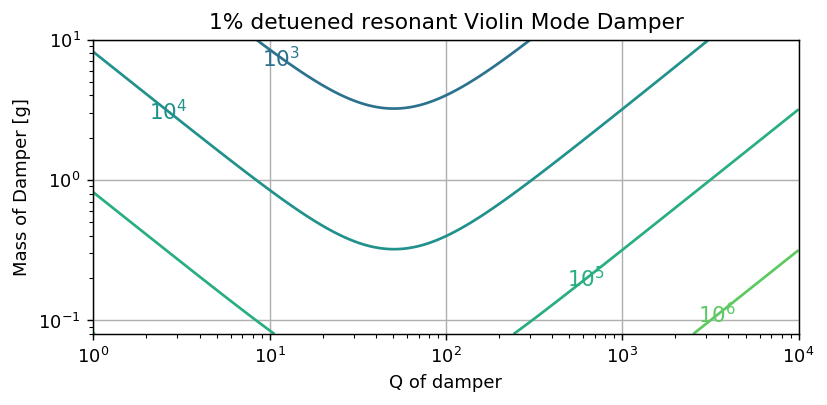

In [15]:
subst = imp.subs([(F, F_vio)]).subs({
        Mtm_kg: 40,
        M_fiber_kg: .005,
        F_vio_Hz: 500,
        detune_F_D_Hz : .01 * 500,
    })
loss_eval = sympy.lambdify([loss_D, M_D], subst / abs(subst), ['numpy', 'math'])

axB = contour_loss(loss_eval)
axB['ax'].set_title('1% detuened resonant Violin Mode Damper')

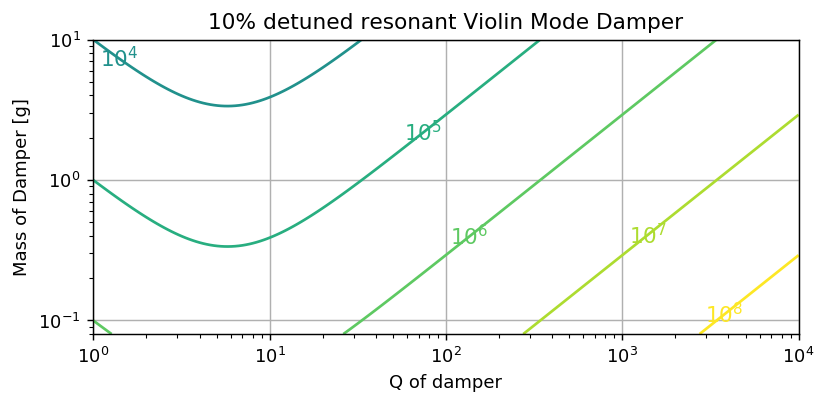

In [16]:
subst = imp.subs([(F, F_vio)]).subs({
        Mtm_kg: 40,
        M_fiber_kg: .005,
        F_vio_Hz: 500,
        detune_F_D_Hz : .10 * 500,
    })
loss_eval = sympy.lambdify([loss_D, M_D], subst / abs(subst), ['numpy', 'math'])

axB = contour_loss(loss_eval)
axB['ax'].set_title('10% detuned resonant Violin Mode Damper')

## Adding the Pendulum Modes

Adding the extra springs of the pendulum is somewhat aggrivating as the usual series/parallel formulas for impedance fail to work. However, the Y$\Delta$ Transform can convert the topology to one that will work:

 * http://www.electronics-tutorials.ws/dccircuits/dcp_10.html
 * https://en.wikipedia.org/wiki/Y-%CE%94_transform
 
Here it is applied between points 1,2,3

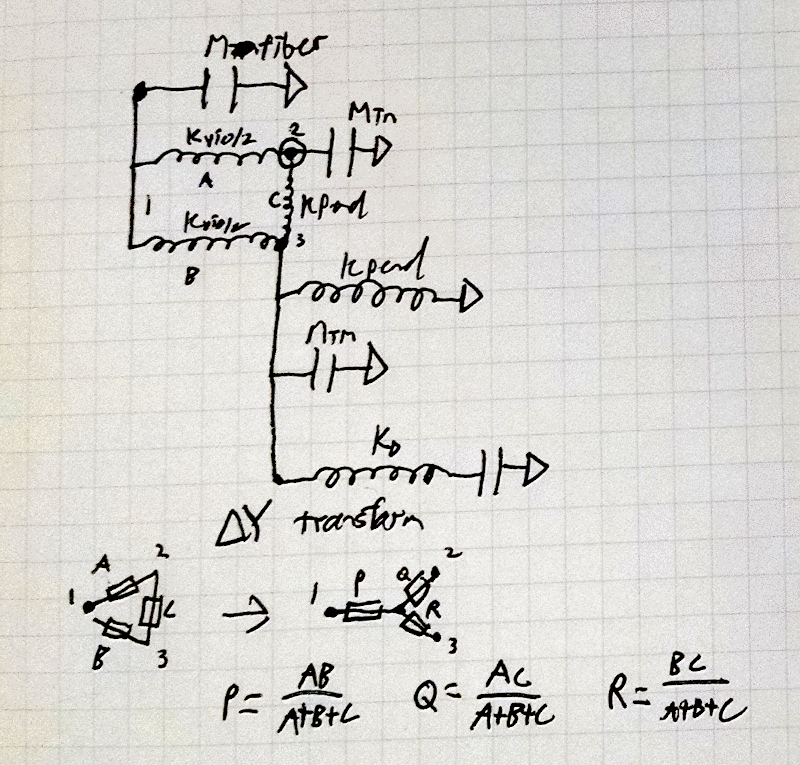

In [17]:
Image('./PendDY.png', embed = True)

This allows a new formulation of the fiber impedance

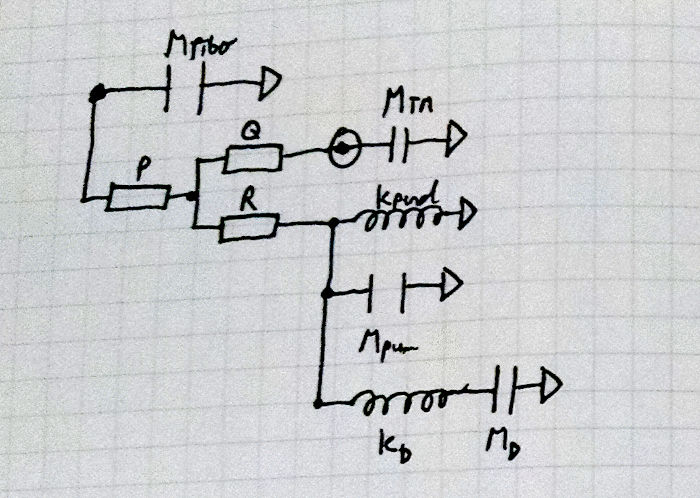

In [18]:
Image('./PendDamper.png', embed = True)

In [19]:
#include the fiber loss as well
A = Zspring(k_fiber_N_m/2, loss = loss_fiber)
B = Zspring(k_fiber_N_m/2, loss = loss_fiber)
C = Zspring(k_pend_N_m, loss = loss_pend)
P = A*B / (A + B + C)
Q = A*C / (A + B + C)
R = C*B / (A + B + C)


imp2 = Zparallel(
    Zmass(M_fiber_kg),
    Zseries(
        P,
        Zparallel(
            Zseries(
                Q,
                Zmass(Mtm_kg),
            ),
            Zseries(
                R, 
                Zparallel(
                    Zspring(k_pendPUM_N_m, loss = loss_pend),
                    Zmass(Mpum_kg),
                    Zseries(
                        Zspring(k_D_N_m, loss = loss_D),
                        Zmass(M_D_kg),
                    )
                )
            ),
        ),
    ),
)
#imp = imp.simplify()
#imp

### Double Check previous results
Check the loss calculation is still good with the pendulum springs installed. This is mostly to check the math. There is also likely some detuning of frequencies as well.

In [20]:
subst = imp2.subs([(F, F_vio)]).subs({
        Mtm_kg: 40,
        M_fiber_kg: .005,
        F_vio_Hz: 500,
        detune_F_D_Hz : 0,
        F_pend_Hz : 1.2,
    })
subst = subst.simplify()

val = subst.subs({
    loss_D: 1e-5, 
    M_D: .00001
})
print("Impedance [s/kg]")
display(abs(val).evalf())
val = (val / abs(val))
print("Relative Loss")
display(sympy.re(val).evalf())

Impedance [s/kg]


Relative Loss


## Setup TestMass Impedance Point

The previous layout is a tree and can be restructured for the impedance to ground of the testmass motion. This will be used to calculate the thermal noise.


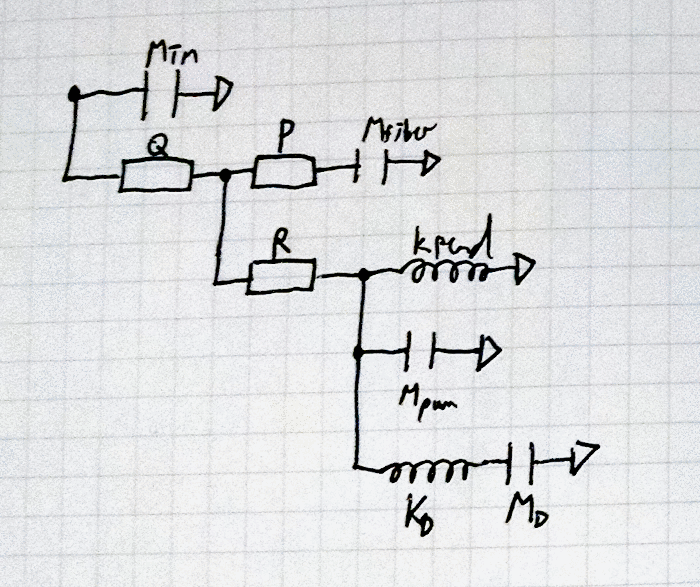

In [21]:
Image('./PendTM.png', embed = True)

At the bottom are the Johnson-Nyquist noise formulas. Since the impedance is it s/kg, the voltage noise version of the formula gives the displacement noise at the testmass. The current noise formula would give the force noise.

In [22]:
impTM = Zparallel(
    Zmass(Mtm_kg),
    Zseries(
        Q,
        Zparallel(
            Zseries(
                P,
                Zmass(M_fiber_kg),
            ),
            Zseries(
                R, 
                Zparallel(
                    #Zspring(k_pendPUM_N_m, loss = loss_pend),
                    Zmass(Mpum_kg),
                    Zseries(
                        Zspring(k_D_N_m, loss = loss_D),
                        Zmass(M_D_kg),
                    )
                )
            ),
        ),
    ),
)
#imp = imp.simplify()
#imp

#the units work. [kg * m**2 / s**2 * K] * [K] * [s / kg] == [(m**2 / s**2) / Hz] then take sqrt for ASD
vel_noise_TM = sympy.sqrt(4 * k_boltzman * temp_K * sympy.re(impTM))
disp_noise_TM = vel_noise_TM / (F * sympy.pi * 2)

In [23]:
subst = disp_noise_TM.subs({
        Mtm_kg: 40,
        M_fiber_kg: .005,
        F_vio_Hz: 500,
        detune_F_D_Hz : 0,
        F_pend_Hz : 1.2,
        #loss_D: 1e-5, 
        #M_D: .00001,
    })

Dnoise_eval = sympy.lambdify([F, M_D, loss_D], subst, ['numpy', 'math'])

print("Displacement Noise[m/rtHz]")
print(Dnoise_eval(500, .001, 1e-2))

Displacement Noise[m/rtHz]
2.90805681995e-18


### Commentary

You you can see a small enhancement to the thermal noise due to the damper. The mode frequency of the pendulum mode is grossly wrong since the violin mode spring constant is sufficiently stiff to dominate the pendulum.

Below an alternate model with intertance attempts to combine the pendulum and violin modes via a capacitive coupling of the violin mode.

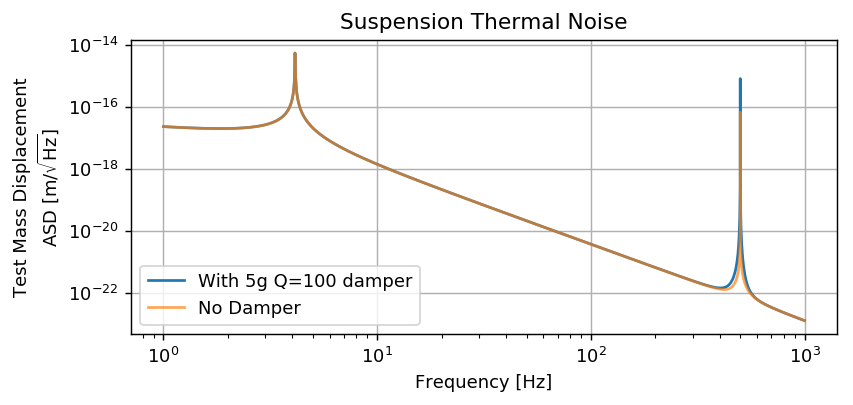

In [24]:
p_F = np.sort(np.concatenate([
    logspaced(1, 1000, 1000),
    np.linspace(499, 501, 10000),
])
)
fig = pylab.figure()
ax = fig.add_subplot(1,1,1)
ax.grid(b=True)
ax.loglog(p_F, Dnoise_eval(p_F, .005, 1e-2), label = 'With 5g Q=100 damper')
ax.loglog(p_F, Dnoise_eval(p_F, .0000005, 1e-1), label = 'No Damper', alpha = .7)
ax.set_title('Suspension Thermal Noise')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Test Mass Displacement\nASD [m/$\\sqrt{\\mathrm{Hz}}$]')
ax.legend(loc = 'lower left')
#ax.axvline(4)

## Experimental Studies With Inerter for violin mode
Don't trust these just yet.

https://en.wikipedia.org/wiki/Inerter_(mechanical_networks)

Since adding the elasticity does not work, The other alternative is that violin modes act as inerter's. This means that the mass-as-capacitor operates in series rather than always connecting to intertial ground.

In [25]:
impTMinerter = Zparallel(
    Zmass(Mtm_kg),
    Zseries(
        Zparallel(
            Zseries(
                Zspring(k_fiber_N_m, loss = loss_fiber),
                Zmass(M_fiber_kg),
            ),
            Zspring(k_pend_N_m, loss = loss_fiber)
        ),
        Zparallel(
            Zmass(Mpum_kg),
            Zseries(
                Zspring(k_D_N_m, loss = loss_D),
                Zmass(M_D_kg),
            ),
        ),
    ),
)
#imp = imp.simplify()
#imp

#the units work. [kg * m**2 / s**2 * K] * [K] * [s / kg] == [(m**2 / s**2) / Hz] then take sqrt for ASD
vel_noise_TM = sympy.sqrt(4 * k_boltzman * temp_K * sympy.re(impTMinerter))
disp_noise_TM = vel_noise_TM / (F * sympy.pi * 2)

In [26]:
subst = disp_noise_TM.subs({
        Mtm_kg: 40,
        M_fiber_kg: .005,
        F_vio_Hz: 500,
        detune_F_D_Hz : 0,
        F_pend_Hz : 1.2,
        #loss_D: 1e-5, 
        #M_D: .00001,
    })

Dnoise_eval = sympy.lambdify([F, M_D, loss_D], subst, ['numpy', 'math'])

print("Displacement Noise[m/rtHz]")
print(Dnoise_eval(500, .001, 1e-2))

Displacement Noise[m/rtHz]
2.89404595746e-18


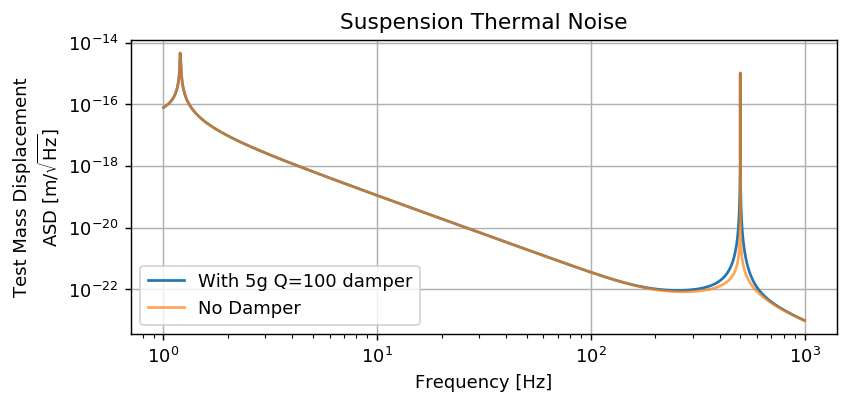

In [27]:
p_F = np.sort(np.concatenate([
    logspaced(1, 1000, 1000),
    np.linspace(499, 501, 10000),
])
)
fig = pylab.figure()
ax = fig.add_subplot(1,1,1)
ax.grid(b=True)
ax.loglog(p_F, Dnoise_eval(p_F, .005, 1e-2), label = 'With 5g Q=100 damper')
ax.loglog(p_F, Dnoise_eval(p_F, .0000005, 1e-1), label = 'No Damper', alpha = .7)
ax.set_title('Suspension Thermal Noise')
ax.set_xlabel('Frequency [Hz]')
ax.set_ylabel('Test Mass Displacement\nASD [m/$\\sqrt{\\mathrm{Hz}}$]')
ax.legend(loc = 'lower left')
#ax.axvline(4)